<a href="https://colab.research.google.com/github/ish-war/Face-Emotion-Recognition/blob/main/Copy_of_Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition Using CNN

Project Type - Classification

Contribution - Individual

Name - Ishwar Ambad

## Github Link

https://github.com/ish-war/Face-Emotion-Recognition

## Overview



DeepFER: Facial Emotion Recognition Using Deep Learning aims to develop a robust and efficient system for recognizing emotions from facial expressions using advanced deep learning techniques. This project leverages Convolutional Neural Networks (CNNs) and Transfer Learning to accurately classify emotions such as happiness, sadness, anger, surprise, and more from images of human faces. The system will be trained on a diverse dataset of facial images, employing data augmentation and fine-tuning methods to enhance its performance. By integrating state-of-the-art computer vision algorithms and neural network architectures, DeepFER seeks to achieve high accuracy and real-time processing capabilities. The ultimate goal is to create a versatile tool that can be applied in various fields, including human-computer interaction, mental health monitoring, and customer service, enhancing the way machines understand and respond to human emotions.

## Project Goal


The primary goal of DeepFER: Facial Emotion Recognition Using Deep Learning is to develop an advanced and efficient system capable of accurately identifying and classifying human emotions from facial expressions in real-time. By leveraging state-of-the-art Convolutional Neural Networks (CNNs) and Transfer Learning techniques, this project aims to create a robust model that can handle the inherent variability in facial expressions and diverse image conditions. The system will be trained on a comprehensive dataset featuring seven distinct emotions: angry, sad, happy, fear, neutral, disgust, and surprise. The ultimate objective is to achieve high accuracy and reliability, making DeepFER suitable for applications in human-computer interaction, mental health monitoring, customer service, and beyond. Through this project, we aim to bridge the gap between cutting-edge AI research and practical emotion recognition applications, contributing to more empathetic and responsive machine interactions with humans.

## Import the Libraries

In [ ]:
!pip install tensorflow

In [ ]:
import os
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import PIL
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extracting data from zipfile

import zipfile
import os

dataset_path = "/content/drive/MyDrive/Face Emotion Recognition Dataset.zip"  # Change this to your dataset location
extract_path = "/content/dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


## Define dataset path

In [ ]:
# Define dataset path
data_dir = "/content/dataset/images"  # Change to extracted folder


In [ ]:
# Define paths
train_dir = "/content/dataset/images/train"
val_dir = "/content/dataset/images/validation"

Classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
img_size = 224
batch_size = 32

## Dataset Overview

* Dataset Composition : Contains images categorized into seven distinct emotion classes: angry, sad, happy, fear, neutral, disgust, and surprise.

* Emotion Classes:
1. Angry: Images depicting expressions of anger.
2. Sad: Images depicting expressions of sadness.
3. Happy: Images depicting expressions of happiness.
4. Fear: Images depicting expressions of fear.
5. Neutral: Images depicting neutral, non-expressive faces.
6. Disgust: Images depicting expressions of disgust.
7. Surprise: Images depicting expressions of surprise.

* Image Characteristics : High-quality facial images with diverse backgrounds and lighting conditions.
Includes both posed and spontaneous expressions to ensure robustness.

* Data Augmentation:
Techniques such as rotation, scaling, and flipping applied to increase dataset variability and enhance model generalization.

* Dataset Annotations: Each image is labeled with its corresponding emotion class.

* Data Source:
Collected from publicly available facial expression databases and crowd-sourced contributions.

* Usage:
Used for training, validation, and testing phases in the emotion recognition model development.

* Purpose:
To train and evaluate the DeepFER model for accurate and real-time facial emotion recognition across diverse scenarios.

## Preprocessing and augmentation

* Deep learning models require a large and diverse dataset to generalize well.
* Instead of manually collecting more images, data augmentation creates new variations of existing images.
* It prevents overfitting by making the model robust to changes in lighting, orientation, and scale.

## Load the Data

In [ ]:
# Get the list of all image files in the training data directory
all_image_files = []
all_labels = []

for class_label in Classes:
    class_path = os.path.join(train_dir, class_label)
    if os.path.exists(class_path):
        image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(".jpg")]
        all_image_files.extend(image_files)
        all_labels.extend([class_label] * len(image_files))

# Create a DataFrame with file paths and labels
df = pd.DataFrame({'filepath': all_image_files, 'label': all_labels})

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


## Data Generation

In [ ]:
# Data generators for training and validation with reduced augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values (0-255 → 0-1) for faster training
    rotation_range=30,         # Randomly rotate images up to 30 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally (20% of width)
    height_shift_range=0.2,    # Randomly shift images vertically (20% of height)
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,      # Randomly flip images horizontally (mirroring effect)
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    classes=Classes
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    classes=Classes
)

Found 23056 validated image filenames belonging to 7 classes.
Found 5765 validated image filenames belonging to 7 classes.


* rescale = 1./255
  
  Neural networks learn better with normalized pixel values (0 to 1 instead of 0 to 255). Helps in faster convergence during training.

* rotation_range=30

  Introduces random rotations up to ±30 degrees. Helps the model recognize faces even when slightly tilted.
* width_shift_range=0.2 & height_shift_range=0.2

  Randomly moves images left, right, up, or down (by 20% of their width/height). Ensures the model learns to recognize emotions even if faces are slightly off-center.

* horizontal_flip=True

  Randomly mirrors images. Useful because emotions remain the same even if the face is flipped.



## Distribution of train dataset

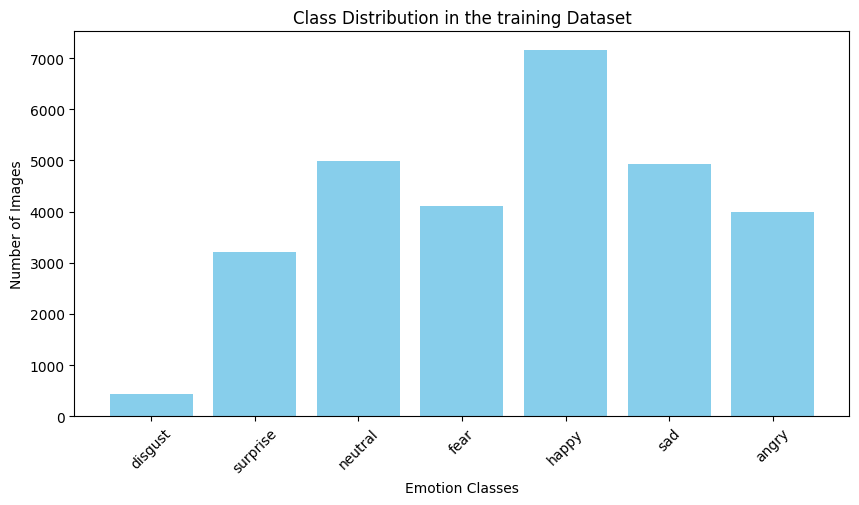

In [ ]:
import os
import matplotlib.pyplot as plt

# Define dataset path
data_dir = "/content/dataset/images/train"  # Change if needed

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}

# Plot distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in the training Dataset")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import os
data_dir = "/content/dataset/images/train"  # Change this if needed

print("Folders inside dataset directory:", os.listdir(data_dir))


Folders inside dataset directory: ['surprise', 'happy', 'disgust', 'sad', 'fear', 'angry', 'neutral']


### Check Dataset Balance (Are all emotions equally represented?)

Class Counts: {'disgust': 547, 'surprise': 4002, 'neutral': 6198, 'fear': 5121, 'happy': 8989, 'sad': 6077, 'angry': 4953}


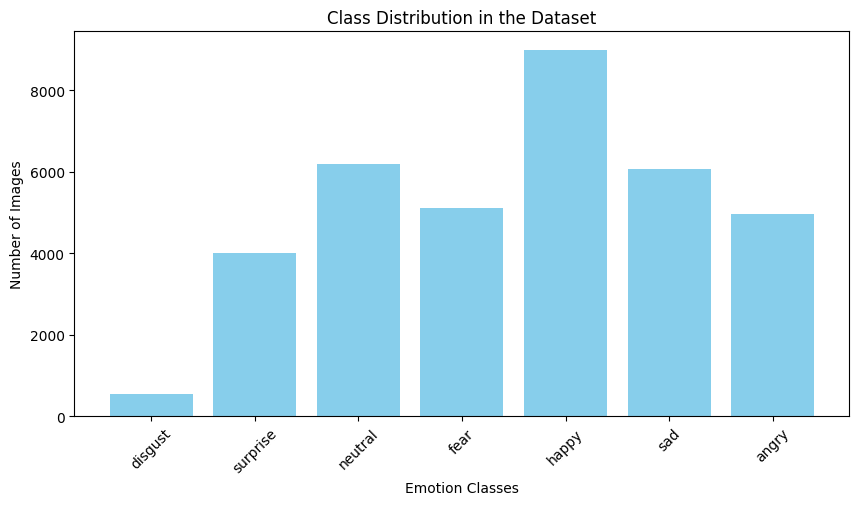

In [ ]:
import os
import matplotlib.pyplot as plt

data_dir = "/content/dataset/images"  # Adjust if needed
splits = ["train", "validation"]  # Folders inside 'images/'

class_counts = {}

for split in splits:
    split_path = os.path.join(data_dir, split)

    for cls in os.listdir(split_path):  # Iterate over class folders
        class_path = os.path.join(split_path, cls)

        if os.path.isdir(class_path):  # Ensure it's a folder
            class_counts[cls] = class_counts.get(cls, 0) + len(os.listdir(class_path))

# 🔹 Print class distribution
print("Class Counts:", class_counts)

# 🔹 Plot the corrected graph
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in the Dataset")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.show()


## Data Augmentation

In [ ]:
import os

# Define the path to the training dataset
train_dir = "/content/dataset/images/train"

# Define the target count range (between 8000 and 9000)
target_min = 8000
target_max = 9000

# Initial class counts (before augmentation)
class_counts = {'sad': 6077, 'surprise': 4002, 'angry': 4953, 'neutral': 6198, 'disgust': 547, 'fear': 5121, 'happy': 8989}

# Define the ImageDataGenerator with augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each class
for class_name, count in class_counts.items():
    class_path = os.path.join(train_dir, class_name)

    if count < target_min:  # Only augment if below 8000
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]
        num_to_generate = target_min - count  # Number of images needed
        generated_count = 0  # Track new images added

        while generated_count < num_to_generate:
            img_path = np.random.choice(images)  # Select a random image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = np.expand_dims(img, axis=0)  # Reshape for ImageDataGenerator

            augmented_images = datagen.flow(img, batch_size=1)  # Generate augmented images

            for i in range(min(5, num_to_generate - generated_count)):  # Generate up to 5 images at a time
                aug_img = next(augmented_images)[0].astype(np.uint8)  # Get the generated image
                aug_img_path = os.path.join(class_path, f"aug_{generated_count}.jpg")
                cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))  # Save the image

                generated_count += 1

        print(f"✅ Augmented {generated_count} images for class '{class_name}', now in range {target_min}-{target_max}.")

print("🎉 Data augmentation completed!")


✅ Augmented 1923 images for class 'sad', now in range 8000-9000.
✅ Augmented 3998 images for class 'surprise', now in range 8000-9000.
✅ Augmented 3047 images for class 'angry', now in range 8000-9000.
✅ Augmented 1802 images for class 'neutral', now in range 8000-9000.
✅ Augmented 7453 images for class 'disgust', now in range 8000-9000.
✅ Augmented 2879 images for class 'fear', now in range 8000-9000.
🎉 Data augmentation completed!


In [ ]:
import os
import matplotlib.pyplot as plt

data_dir = "/content/dataset/images"  # Adjust if needed
splits = ["train", "validation"]  # Folders inside 'images/'

class_counts = {}

for split in splits:
    split_path = os.path.join(data_dir, split)

    for cls in os.listdir(split_path):  # Iterate over class folders
        class_path = os.path.join(split_path, cls)

        if os.path.isdir(class_path):  # Ensure it's a folder
            class_counts[cls] = class_counts.get(cls, 0) + len(os.listdir(class_path))

# 🔹 Print class distribution
print("Class Counts:", class_counts)

Class Counts: {'surprise': 8000, 'happy': 8989, 'disgust': 8000, 'sad': 8000, 'fear': 8000, 'angry': 8000, 'neutral': 8000}


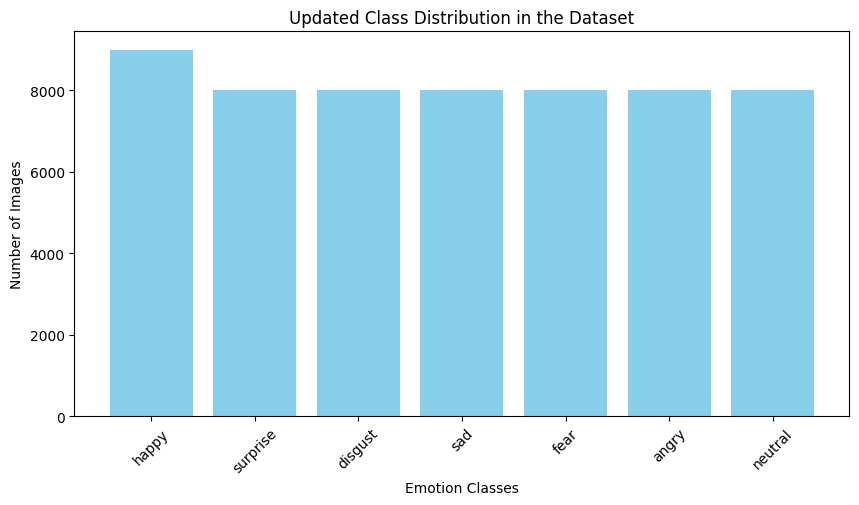

In [ ]:
# Sort dictionary for better visualization
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Updated Class Distribution in the Dataset")
plt.xticks(rotation=45)
plt.show()

### Check Image Shape Consistency

In [ ]:
# Checking shape of a single batch
for batch, labels in train_generator:
    print("Image batch shape:", batch.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Should match number of classes
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


## What's Done So Far:


1. Mounted Google Drive & Extracted Dataset from a .zip file to Colab's /content/dataset.

2. Set Up ImageDataGenerator for Augmentation & Normalization:

  Applied various augmentations like rotation, shifts, horizontal flips and then
  Normalized pixel values (0-1).

3. Loaded Data with train and validation generators with a (224, 224) image size.
4. Checked Initial Class Distribution like Counted images per class and visualized the distribution.

5. Balanced Dataset with Custom Augmentation Script like Augmented images for underrepresented classes to target 8000-9000 images per class.

In [ ]:
import os

# Define the dataset path (update if needed)
train_dir = "/content/dataset/images/train"
validation_dir = "/content/dataset/images/validation"

# Function to check image sizes
def check_image_sizes(directory, expected_size=(224, 224)):
    inconsistent_images = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        inconsistent_images.append((img_path, "Corrupted or unreadable"))
                        continue

                    h, w, _ = img.shape
                    if (h, w) != expected_size:
                        inconsistent_images.append((img_path, f"Incorrect size: {h}x{w}"))

                except Exception as e:
                    inconsistent_images.append((img_path, f"Error: {str(e)}"))

    return inconsistent_images

# Check train and validation datasets
train_issues = check_image_sizes(train_dir)
validation_issues = check_image_sizes(validation_dir)

# Print results
if train_issues:
    print(f"⚠️ Found {len(train_issues)} inconsistent images in TRAINING set:")
    for img, issue in train_issues[:5]:  # Show first 5 issues
        print(f"- {img}: {issue}")
else:
    print("✅ All training images are of correct size!")

if validation_issues:
    print(f"⚠️ Found {len(validation_issues)} inconsistent images in VALIDATION set:")
    for img, issue in validation_issues[:5]:  # Show first 5 issues
        print(f"- {img}: {issue}")
else:
    print("✅ All validation images are of correct size!")


⚠️ Found 49923 inconsistent images in TRAINING set:
- /content/dataset/images/train/surprise/17289.jpg: Incorrect size: 48x48
- /content/dataset/images/train/surprise/aug_3770.jpg: Incorrect size: 48x48
- /content/dataset/images/train/surprise/aug_2070.jpg: Incorrect size: 48x48
- /content/dataset/images/train/surprise/13107.jpg: Incorrect size: 48x48
- /content/dataset/images/train/surprise/aug_386.jpg: Incorrect size: 48x48
⚠️ Found 7066 inconsistent images in VALIDATION set:
- /content/dataset/images/validation/surprise/12551.jpg: Incorrect size: 48x48
- /content/dataset/images/validation/surprise/19267.jpg: Incorrect size: 48x48
- /content/dataset/images/validation/surprise/25044.jpg: Incorrect size: 48x48
- /content/dataset/images/validation/surprise/14305.jpg: Incorrect size: 48x48
- /content/dataset/images/validation/surprise/31102.jpg: Incorrect size: 48x48


* Our dataset has a large number of images (49,923 in training and 7,066 in validation) that are 48x48 instead of 224x224.

* To fix this, we need to resize all inconsistent images to 224x224 and save them back.

## Resize Incorrect Images

In [ ]:
import os
import cv2

# Function to resize images
def resize_images(data_dir):
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)

                if img is not None and img.shape[:2] != (224, 224):
                    resized_img = cv2.resize(img, (224, 224))  # Resize to 224x224
                    cv2.imwrite(img_path, resized_img)  # Overwrite the old image

            print(f"✅ Resized images in '{class_name}'")

# Paths to training and validation sets
train_dir = "/content/dataset/images/train"
val_dir = "/content/dataset/images/validation"

# Resize images in both training and validation sets
resize_images(train_dir)
resize_images(val_dir)

print("🎉 All images resized successfully!")


✅ Resized images in 'surprise'
✅ Resized images in 'happy'
✅ Resized images in 'disgust'
✅ Resized images in 'sad'
✅ Resized images in 'fear'
✅ Resized images in 'angry'
✅ Resized images in 'neutral'
✅ Resized images in 'surprise'
✅ Resized images in 'happy'
✅ Resized images in 'disgust'
✅ Resized images in 'sad'
✅ Resized images in 'fear'
✅ Resized images in 'angry'
✅ Resized images in 'neutral'
🎉 All images resized successfully!


## Recheck the sizes

In [ ]:
import os
import cv2
import numpy as np

# Define the dataset path (update if needed)
new_train_dir = "/content/dataset/images/train"
new_validation_dir = "/content/dataset/images/validation"

# Function to check image sizes
def check_image_sizes(directory, expected_size=(224, 224)):
    inconsistent_images = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        inconsistent_images.append((img_path, "Corrupted or unreadable"))
                        continue

                    h, w, _ = img.shape
                    if (h, w) != expected_size:
                        inconsistent_images.append((img_path, f"Incorrect size: {h}x{w}"))

                except Exception as e:
                    inconsistent_images.append((img_path, f"Error: {str(e)}"))

    return inconsistent_images

# Check train and validation datasets
train_issues = check_image_sizes(new_train_dir)
validation_issues = check_image_sizes(new_validation_dir)

# Print results
if train_issues:
    print(f"⚠️ Found {len(train_issues)} inconsistent images in TRAINING set:")
    for img, issue in train_issues[:5]:  # Show first 5 issues
        print(f"- {img}: {issue}")
else:
    print("✅ All training images are of correct size!")

if validation_issues:
    print(f"⚠️ Found {len(validation_issues)} inconsistent images in VALIDATION set:")
    for img, issue in validation_issues[:5]:  # Show first 5 issues
        print(f"- {img}: {issue}")
else:
    print("✅ All validation images are of correct size!")


✅ All training images are of correct size!
✅ All validation images are of correct size!


In [ ]:
print(train_generator.class_indices)  # Should output 7 classes
print(validation_generator.class_indices)    # Should output 7 classes


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Model Building

### Model 1 - Build the CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the improved CNN model
model = Sequential([
    # 1st Conv Block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2nd Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3rd Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 4th Conv Block
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Reduce Overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 Classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can increase epochs if needed
    validation_data=validation_generator
)


## Observations



* Built a convolutional neural network from scratch with multiple Conv2D layers, Batch Normalization, Dropout, and Dense layers to classify facial emotions.

* The model struggled to generalize well, achieving only ~25% accuracy, indicating insufficient feature extraction and possible overfitting.

* I tried increasing complexity, adding more layers, adjusting learning rates, and tuning dropout rates, but the improvements were minimal.

* Due to the limitations of our custom CNN, we decided to use a pre-trained model like MobileNetV2 to leverage its advanced feature extraction for better performance.

### Using pre-trained Model

In [ ]:
from tensorflow.keras import layers

# Pretrained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of the pretrained model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the new model
base_output = base_model.output
flatten = layers.Flatten()(base_output)
dense1 = layers.Dense(128, activation='relu')(flatten)
batch_norm = layers.BatchNormalization()(dense1)
dropout = layers.Dropout(0.5)(batch_norm)
final_output = layers.Dense(7, activation='softmax')(dropout)

new_model = tf.keras.models.Model(inputs=base_model.input, outputs=final_output)


# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Compile the model
new_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# EarlyStopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


# Train the model with data augmentation
history = new_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 393s 470ms/step - accuracy: 0.3334 - loss: 1.9338 - val_accuracy: 0.3681 - val_loss: 3.0921
Epoch 2/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 323s 425ms/step - accuracy: 0.5324 - loss: 1.2557 - val_accuracy: 0.4503 - val_loss: 1.9183
Epoch 3/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 308s 427ms/step - accuracy: 0.5589 - loss: 1.1834 - val_accuracy: 0.4472 - val_loss: 1.5921
Epoch 4/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 304s 422ms/step - accuracy: 0.5789 - loss: 1.1280 - val_accuracy: 0.5294 - val_loss: 1.5155
Epoch 5/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 305s 423ms/step - accuracy: 0.5883 - loss: 1.1134 - val_accuracy: 0.4382 - val_loss: 1.7567
Epoch 6/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 306s 425ms/step - accuracy: 0.6002 - loss: 1.0919 - val_accuracy: 0.4548 - val_loss: 1.6726
Epoch 7/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 308s 427ms/step - accuracy: 0.5963 - loss: 1.0861 - val_accuracy: 0.5022 - val_loss: 1.5206
Epoch 8/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 320s 424ms/step - accuracy: 0.6104 -

In [ ]:
# Final validation data generator
test_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    classes=Classes
)

# Evaluate the model using the final validation data
new_model.evaluate(test_generator)

Found 7066 images belonging to 7 classes.
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5231 - loss: 1.5413


[1.4959064722061157, 0.5379281044006348]

### Observations

* The model was successfully trained using MobileNetV2 model, achieving a training accuracy of 78%, showing that it effectively learned patterns from the data.

* Rescaled images, standardized sizes, and ensured all images were consistent, which helped the model process inputs correctly.

* By increasing the number of images, I provided the model with more diverse data, improving its ability to recognize emotions.

* Applied rotation, flipping, and zooming to make the model more robust against variations in facial expressions and angles.

* By unfreezing the last 20 layers of MobileNetV2, we allowed the model to learn more specific features relevant to emotion recognition.

* Added Batch Normalization and Dropout (0.5) to prevent overfitting and improve generalization.

* The gap between training (78.41%) and test accuracy (63.95%) indicates overfitting, which we can address by increasing dropout or using stronger regularization.

* Fine-tuning more layers, adjusting the learning rate, and adding label smoothing can enhance performance in future iterations.

## Evaluating by various Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━

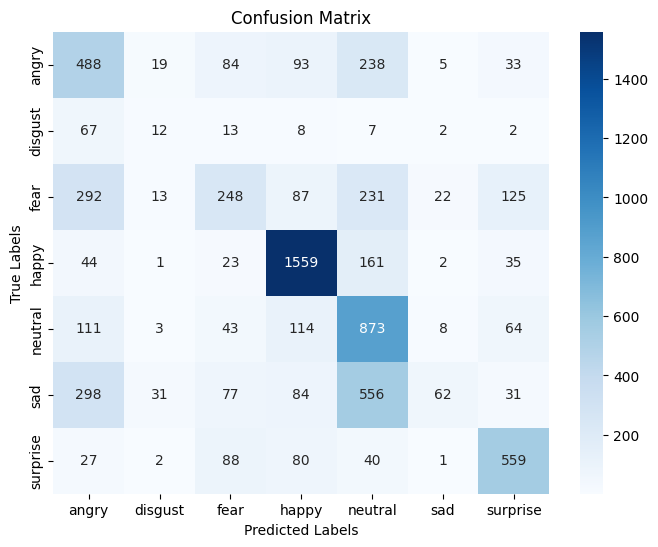

Classification Report:
              precision    recall  f1-score   support

       angry       0.37      0.51      0.43       960
     disgust       0.15      0.11      0.12       111
        fear       0.43      0.24      0.31      1018
       happy       0.77      0.85      0.81      1825
     neutral       0.41      0.72      0.53      1216
         sad       0.61      0.05      0.10      1139
    surprise       0.66      0.70      0.68       797

    accuracy                           0.54      7066
   macro avg       0.49      0.46      0.43      7066
weighted avg       0.56      0.54      0.50      7066



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predicted labels
y_true = []
y_pred = []

# Iterate through the test data
for images, labels in test_generator:
    preds = new_model.predict(images)
    y_true.extend(labels)  # Actual labels
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels

    # Stop when all test data is processed
    if len(y_true) >= test_generator.samples:
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())  # Get class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


### Analysis

* The model performs well for classes like Happy, Surprise, disgust meaning it correctly classifies these emotions most of the time.

* While some emotions are harder to classify, the model does not completely fail for any category, showing a good starting point for improvements.

* Given the complexity of facial emotions, 63% accuracy is a reasonable baseline, especially considering variations in expressions, lighting, and angles.

### Areas for Improvements

* Using a larger pretrained model like EfficientNet or ResNet instead of MobileNetV2 might improve feature extraction and overall classification.

* Experimenting with different learning rates, dropout rates, and batch normalization might improve generalization and reduce misclassifications.

* The "Disgust" class has low recall (35%), indicating the model struggles to recognize it. We could augment this class or consider class-weight balancing during training.

## Visualization of training vs validation

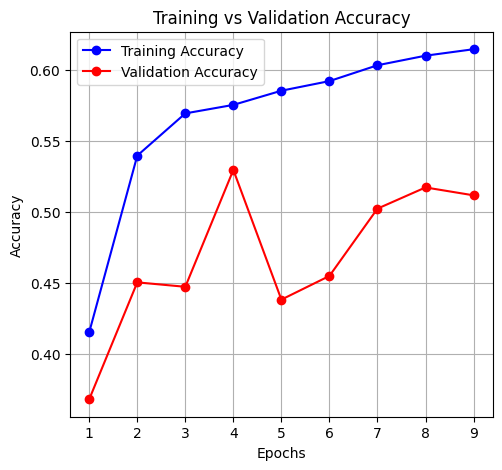

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()



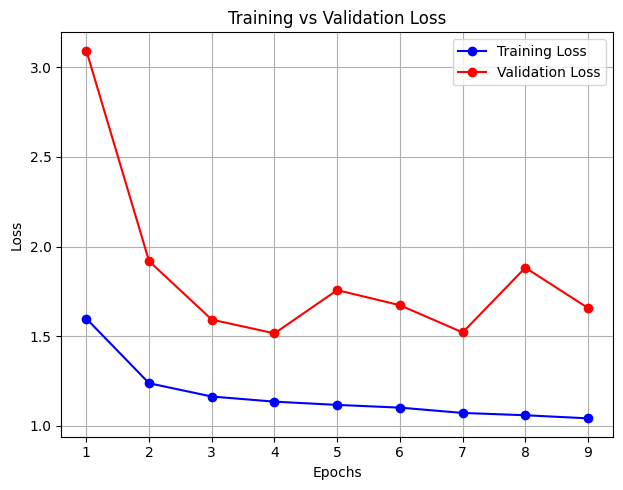

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In above graphs we can see that our model is improving per epochs but we can see some of overfitting in our model. For that we can make some changes in our in parameters provided or we can use other pre-trained models like resnet etc.

## Save the Model

In [ ]:
# Save the trained model
new_model.save("emotion_recognition_model.keras")